In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 600

# Part 0: Load Data

## Immune Cell Fractions

CIBERSORT result from [*The Immune Landscape of Cancer*](https://www.sciencedirect.com/science/article/pii/S1074761318301213) downloaded from [NIH PanCanAtlas](https://gdc.cancer.gov/about-data/publications/panimmune) includes are SampleID ([TCGA barcode](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/)), Cancer Type ([TCGA Study Abbreviation](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations)), and the abundance of 22 imuune cell types.

Note that the abundances in each row sum to 1. In other words, the abundance is the proportion of a cell type in the leukocyte compartment (see [below](#lf)), but not all cells (stroma, tumor, etc.).

In [2]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
0,TCGA-OR-A5JG-01A-11R-A29S-07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.363861,0.002715,0.026125,0.032788,0.000000,0.010290,0.009607,0.112,0.095797,1.047142
1,TCGA-OR-A5LG-01A-11R-A29S-07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.448243,0.000000,0.007464,0.126237,0.000000,0.000000,0.000000,0.104,0.103345,1.046163
2,TCGA-OR-A5JD-01A-11R-A29S-07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.329552,0.000000,0.009330,0.000000,0.190730,0.000000,0.000000,0.068,0.143259,1.039812
3,TCGA-OR-A5LH-01A-11R-A29S-07,ACC,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,...,0.287939,0.000000,0.000576,0.000000,0.064725,0.000000,0.000000,0.388,0.028763,1.080553
4,TCGA-OR-A5KY-01A-11R-A29S-07,ACC,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,...,0.486400,0.000000,0.042827,0.000000,0.017418,0.014769,0.000000,0.246,0.055621,1.073474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,TCGA-V4-A9EQ-01A-11R-A405-07,UVM,0.000000,0.028939,0.008894,0.000000,0.023294,0.015676,0.0,0.002279,...,0.521353,0.009128,0.000000,0.208036,0.000000,0.000000,0.000000,0.090,0.111538,1.060529
11369,TCGA-V4-A9EV-01A-11R-A405-07,UVM,0.000000,0.013299,0.025069,0.315356,0.000000,0.017361,0.0,0.095233,...,0.163671,0.015558,0.000000,0.061707,0.000000,0.000000,0.000000,0.002,0.347125,0.952021
11370,TCGA-V4-A9EY-01A-11R-A405-07,UVM,0.000000,0.032507,0.076160,0.061400,0.034359,0.000000,0.0,0.007778,...,0.431568,0.004550,0.000000,0.227797,0.000000,0.000000,0.000000,0.086,0.113888,1.041876
11371,TCGA-V4-A9EU-01A-11R-A405-07,UVM,0.000000,0.021228,0.010225,0.067985,0.003434,0.006675,0.0,0.004884,...,0.627631,0.000000,0.000000,0.147489,0.000000,0.000000,0.000000,0.096,0.107852,1.068155


In [3]:
tcga_study_abbr_dict = {
    "LAML": "Acute Myeloid Leukemia",
    "ACC": "Adrenocortical carcinoma",
    "BLCA": "Bladder Urothelial Carcinoma",
    "LGG": "Brain Lower Grade Glioma",
    "BRCA": "Breast invasive carcinoma",
    "CESC": "Cervical squamous cell carcinoma and endocervical adenocarcinoma",
    "CHOL": "Cholangiocarcinoma",
    "LCML": "Chronic Myelogenous Leukemia",
    "COAD": "Colon adenocarcinoma",
    "CNTL": "Controls",
    "ESCA": "Esophageal carcinoma",
    "FPPP": "FFPE Pilot Phase II",
    "GBM": "Glioblastoma multiforme",
    "HNSC": "Head and Neck squamous cell carcinoma",
    "KICH": "Kidney Chromophobe",
    "KIRC": "Kidney renal clear cell carcinoma",
    "KIRP": "Kidney renal papillary cell carcinoma",
    "LIHC": "Liver hepatocellular carcinoma",
    "LUAD": "Lung adenocarcinoma",
    "LUSC": "Lung squamous cell carcinoma",
    "DLBC": "Lymphoid Neoplasm Diffuse Large B-cell Lymphoma",
    "MESO": "Mesothelioma",
    "MISC": "Miscellaneous",
    "OV": "Ovarian serous cystadenocarcinoma",
    "PAAD": "Pancreatic adenocarcinoma",
    "PCPG": "Pheochromocytoma and Paraganglioma",
    "PRAD": "Prostate adenocarcinoma",
    "READ": "Rectum adenocarcinoma",
    "SARC": "Sarcoma",
    "SKCM": "Skin Cutaneous Melanoma",
    "STAD": "Stomach adenocarcinoma",
    "TGCT": "Testicular Germ Cell Tumors",
    "THYM": "Thymoma",
    "THCA": "Thyroid carcinoma",
    "UCS": "Uterine Carcinosarcoma",
    "UCEC": "Uterine Corpus Endometrial Carcinoma",
    "UVM": "Uveal Melanoma"
}

tcga_study_abbr_dict2 = {k: v + ' (' + k + ')' for k, v in tcga_study_abbr_dict.items()}
tcga_study_abbr_dict2

{'LAML': 'Acute Myeloid Leukemia (LAML)',
 'ACC': 'Adrenocortical carcinoma (ACC)',
 'BLCA': 'Bladder Urothelial Carcinoma (BLCA)',
 'LGG': 'Brain Lower Grade Glioma (LGG)',
 'BRCA': 'Breast invasive carcinoma (BRCA)',
 'CESC': 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)',
 'CHOL': 'Cholangiocarcinoma (CHOL)',
 'LCML': 'Chronic Myelogenous Leukemia (LCML)',
 'COAD': 'Colon adenocarcinoma (COAD)',
 'CNTL': 'Controls (CNTL)',
 'ESCA': 'Esophageal carcinoma (ESCA)',
 'FPPP': 'FFPE Pilot Phase II (FPPP)',
 'GBM': 'Glioblastoma multiforme (GBM)',
 'HNSC': 'Head and Neck squamous cell carcinoma (HNSC)',
 'KICH': 'Kidney Chromophobe (KICH)',
 'KIRC': 'Kidney renal clear cell carcinoma (KIRC)',
 'KIRP': 'Kidney renal papillary cell carcinoma (KIRP)',
 'LIHC': 'Liver hepatocellular carcinoma (LIHC)',
 'LUAD': 'Lung adenocarcinoma (LUAD)',
 'LUSC': 'Lung squamous cell carcinoma (LUSC)',
 'DLBC': 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)',
 'MESO': 'Meso

In [4]:
tcga_study_abbr_dict2 = {k: v + ' (' + k + ')' for k, v in tcga_study_abbr_dict.items()}
tcga_study_abbr_dict2

{'LAML': 'Acute Myeloid Leukemia (LAML)',
 'ACC': 'Adrenocortical carcinoma (ACC)',
 'BLCA': 'Bladder Urothelial Carcinoma (BLCA)',
 'LGG': 'Brain Lower Grade Glioma (LGG)',
 'BRCA': 'Breast invasive carcinoma (BRCA)',
 'CESC': 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)',
 'CHOL': 'Cholangiocarcinoma (CHOL)',
 'LCML': 'Chronic Myelogenous Leukemia (LCML)',
 'COAD': 'Colon adenocarcinoma (COAD)',
 'CNTL': 'Controls (CNTL)',
 'ESCA': 'Esophageal carcinoma (ESCA)',
 'FPPP': 'FFPE Pilot Phase II (FPPP)',
 'GBM': 'Glioblastoma multiforme (GBM)',
 'HNSC': 'Head and Neck squamous cell carcinoma (HNSC)',
 'KICH': 'Kidney Chromophobe (KICH)',
 'KIRC': 'Kidney renal clear cell carcinoma (KIRC)',
 'KIRP': 'Kidney renal papillary cell carcinoma (KIRP)',
 'LIHC': 'Liver hepatocellular carcinoma (LIHC)',
 'LUAD': 'Lung adenocarcinoma (LUAD)',
 'LUSC': 'Lung squamous cell carcinoma (LUSC)',
 'DLBC': 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)',
 'MESO': 'Meso

In [5]:
data["CancerType"].value_counts().index

Index(['BRCA', 'KIRC', 'LUAD', 'UCEC', 'THCA', 'HNSC', 'PRAD', 'LUSC', 'COAD',
       'LGG', 'SKCM', 'STAD', 'BLCA', 'OV', 'LIHC', 'KIRP', 'CESC', 'SARC',
       'ESCA', 'PCPG', 'PAAD', 'LAML', 'READ', 'GBM', 'TGCT', 'THYM', 'KICH',
       'MESO', 'UVM', 'ACC', 'UCS', 'DLBC', 'CHOL'],
      dtype='object')

[Text(0, 0, 'Breast invasive carcinoma (BRCA)'),
 Text(0, 0, 'Kidney renal clear cell carcinoma (KIRC)'),
 Text(0, 0, 'Lung adenocarcinoma (LUAD)'),
 Text(0, 0, 'Uterine Corpus Endometrial Carcinoma (UCEC)'),
 Text(0, 0, 'Thyroid carcinoma (THCA)'),
 Text(0, 0, 'Head and Neck squamous cell carcinoma (HNSC)'),
 Text(0, 0, 'Prostate adenocarcinoma (PRAD)'),
 Text(0, 0, 'Lung squamous cell carcinoma (LUSC)'),
 Text(0, 0, 'Colon adenocarcinoma (COAD)'),
 Text(0, 0, 'Brain Lower Grade Glioma (LGG)'),
 Text(0, 0, 'Skin Cutaneous Melanoma (SKCM)'),
 Text(0, 0, 'Stomach adenocarcinoma (STAD)'),
 Text(0, 0, 'Bladder Urothelial Carcinoma (BLCA)'),
 Text(0, 0, 'Ovarian serous cystadenocarcinoma (OV)'),
 Text(0, 0, 'Liver hepatocellular carcinoma (LIHC)'),
 Text(0, 0, 'Kidney renal papillary cell carcinoma (KIRP)'),
 Text(0, 0, 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)'),
 Text(0, 0, 'Sarcoma (SARC)'),
 Text(0, 0, 'Esophageal carcinoma (ESCA)'),
 Text(0, 0, 'Pheochro

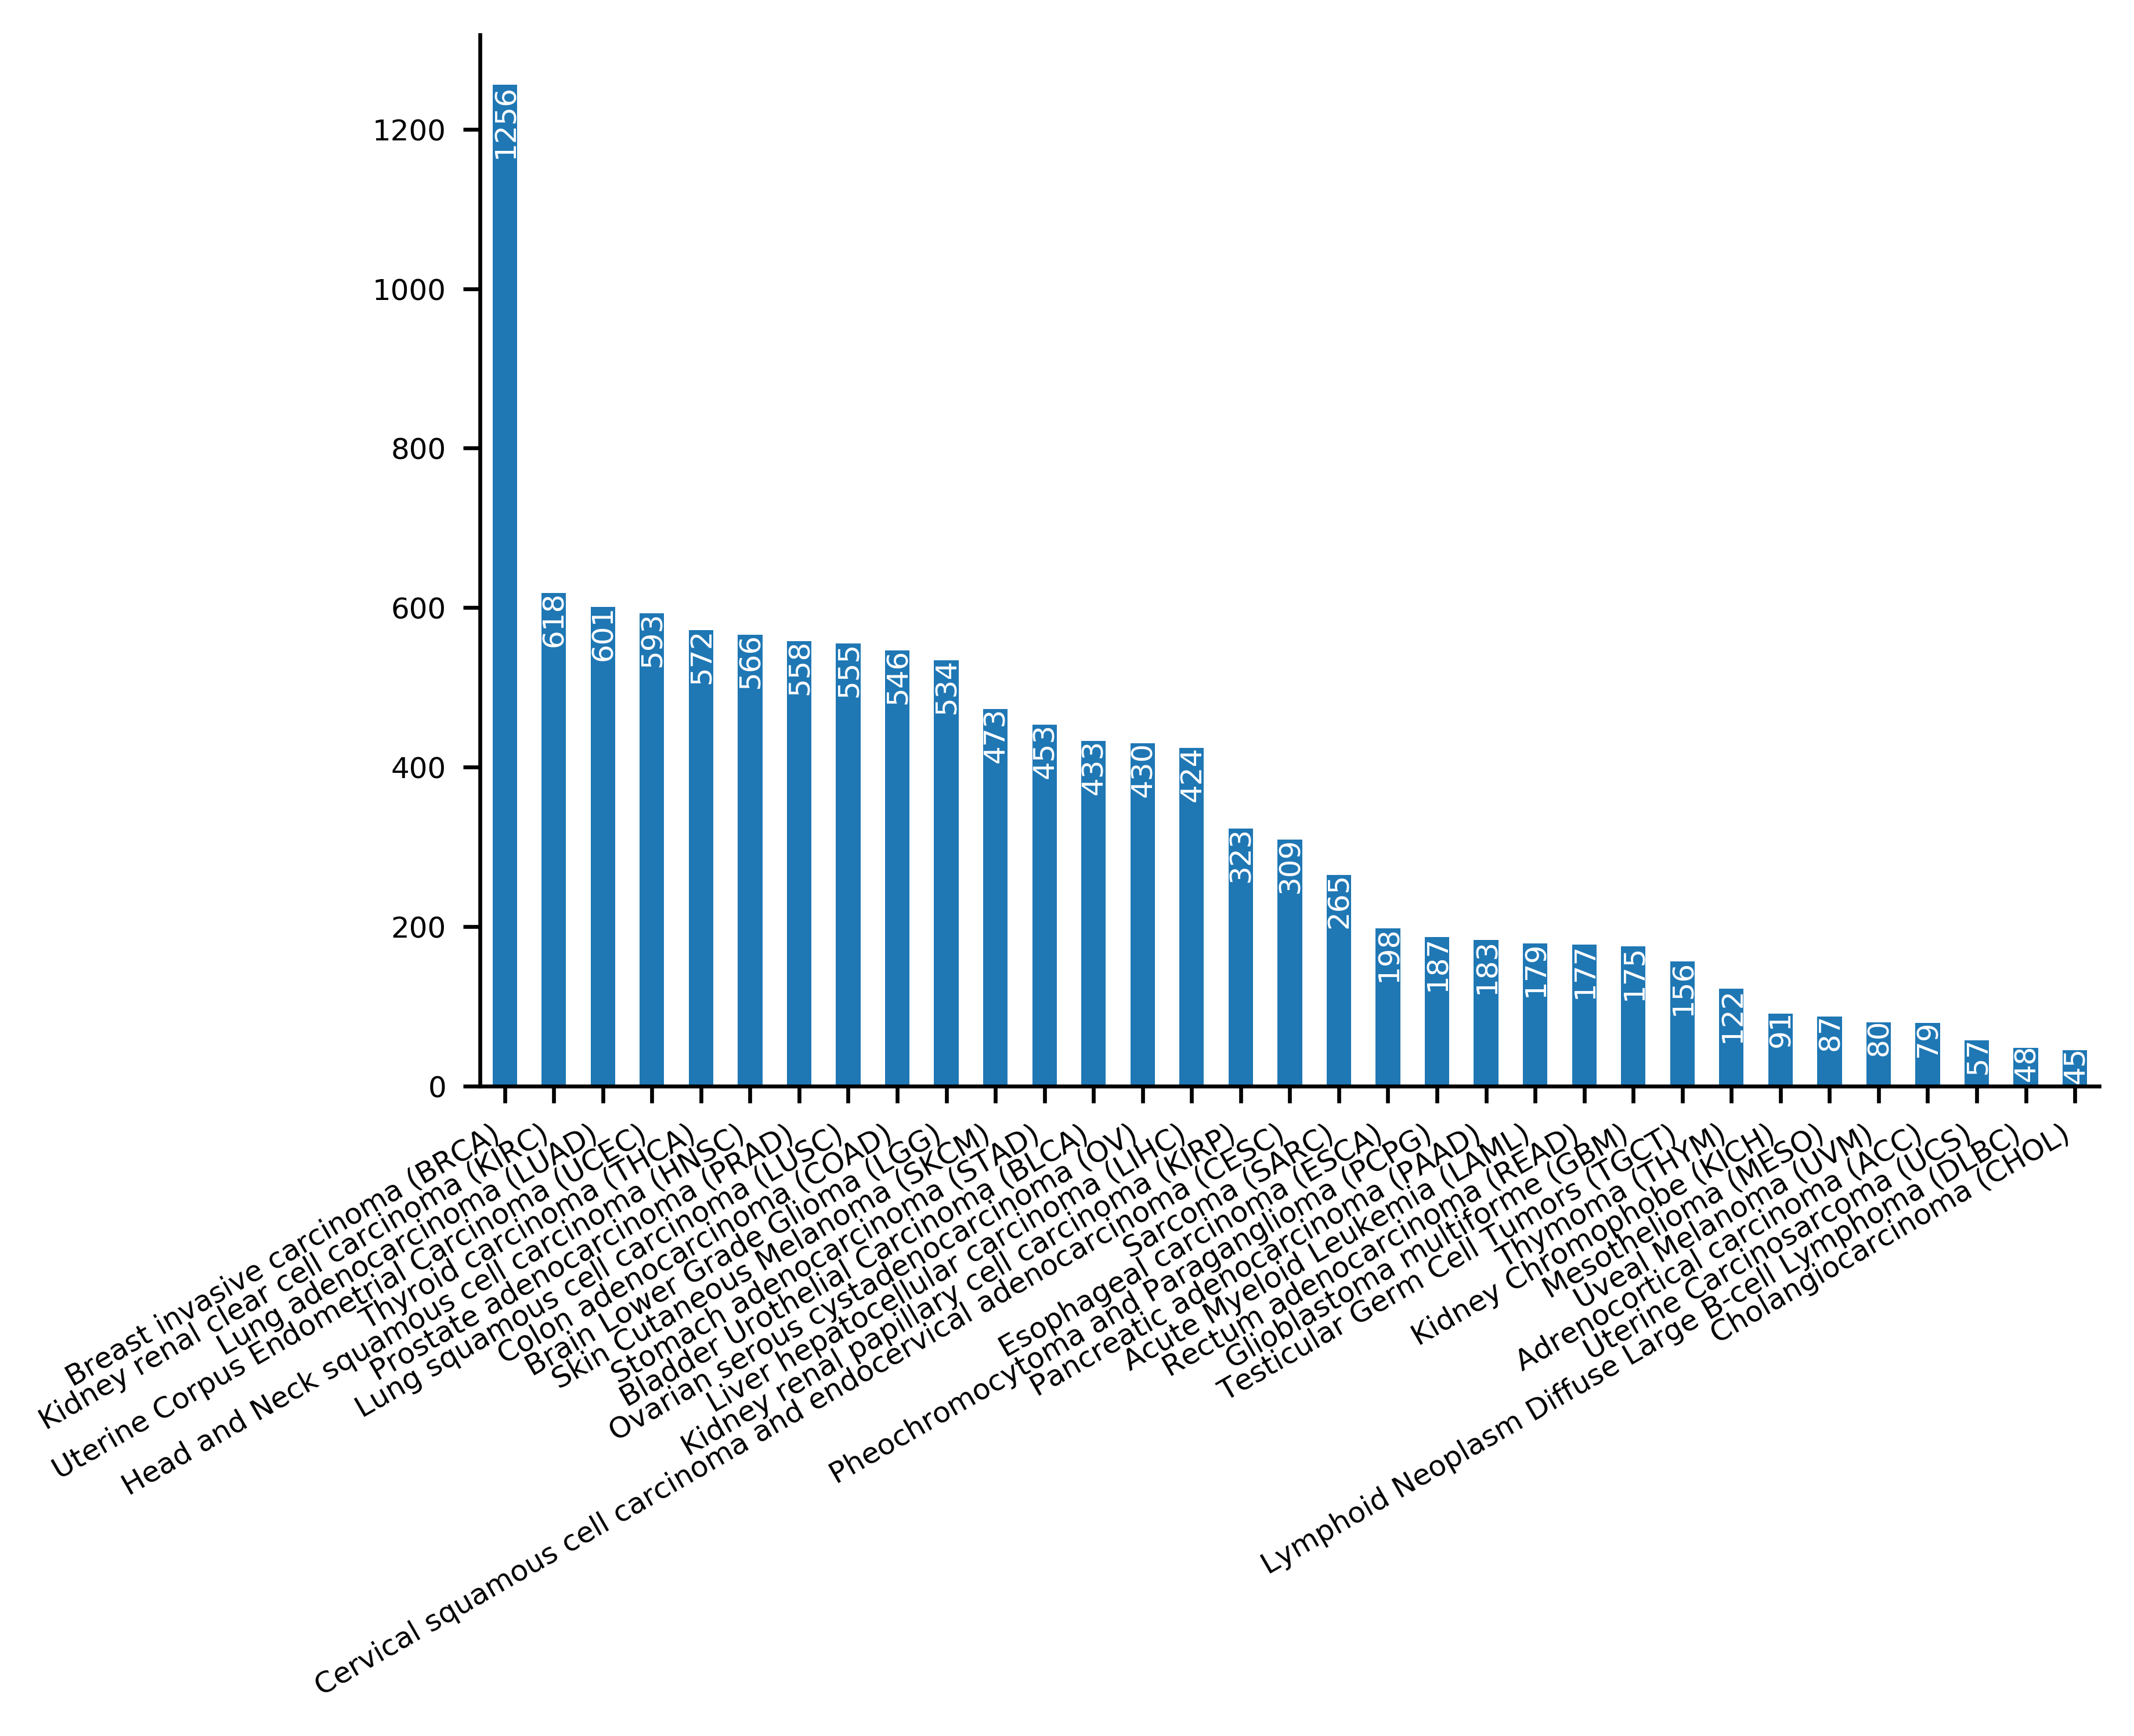

In [6]:
ax = data["CancerType"].apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind='bar')

for i in ax.patches:
    if i.get_height() >= 1:
        ax.text(i.get_x()+0.55, i.get_height() - 25 * len(str(int(round(i.get_height())))) + 15, 
                str(int(round(i.get_height()))), fontsize=6, rotation=90, color='w', ha='right')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.tick_params(axis="y", labelsize=6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=6)

In [7]:
data[data['SampleID'] == 'TCGA-A7-A0DC-01B-04R-A22O-07']

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
1762,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.095566,0.045122,0.018111,0.130455,0.172505,0.0,0.0,...,0.115555,0.0,0.067555,0.251592,0.0,0.000000,0.0,0.108,0.099062,1.040622
1763,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.113939,0.040357,0.005743,0.067493,0.214965,0.0,0.0,...,0.125661,0.0,0.058962,0.278053,0.0,0.000000,0.0,0.138,0.078372,1.048953
1764,TCGA-A7-A0DC-01B-04R-A22O-07,BRCA,0.0,0.133703,0.046857,0.018552,0.031506,0.225782,0.0,0.0,...,0.104292,0.0,0.078465,0.211148,0.0,0.001334,0.0,0.244,0.045592,1.056600


In [8]:
tcga_sample_type_dict = {
    "01": "Primary Solid Tumor",
    "02": "Recurrent Solid Tumor",
    "03": "Primary Blood Derived Cancer - Peripheral Blood",
    "04": "Recurrent Blood Derived Cancer - Bone Marrow",
    "05": "Additional - New Primary",
    "06": "Metastatic",
    "07": "Additional Metastatic",
    "08": "Human Tumor Original Cells",
    "09": "Primary Blood Derived Cancer - Bone Marrow",
    "10": "Blood Derived Normal",
    "11": "Solid Tissue Normal",
    "12": "Buccal Cell Normal",
    "13": "EBV Immortalized Normal",
    "14": "Bone Marrow Normal",
    "15": "sample type 15",
    "16": "sample type 16",
    "20": "Control Analyte",
    "40": "Recurrent Blood Derived Cancer - Peripheral Blood",
    "50": "Cell Lines",
    "60": "Primary Xenograft Tissue",
    "61": "Cell Line Derived Xenograft Tissue",
    "99": "sample type 99"
}

# Basic statistics

In [9]:
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
all_data = data.copy()
all_data["SampleType"] = all_data["SampleID"].apply(f)
all_data.groupby(["CancerType", "SampleType"]).SampleID.count().to_frame()

SampleID
CancerType SampleType                     
ACC        Primary Solid Tumor          79
BLCA       Primary Solid Tumor         414
           Solid Tissue Normal          19
BRCA       Metastatic                    7
           Primary Solid Tumor        1135
...                                    ...
UCEC       Primary Solid Tumor         557
           Recurrent Solid Tumor         1
           Solid Tissue Normal          35
UCS        Primary Solid Tumor          57
UVM        Primary Solid Tumor          80

[82 rows x 1 columns]

In [10]:
all_data.SampleType.unique().tolist()

['Primary Solid Tumor',
 'Solid Tissue Normal',
 'Metastatic',
 'Recurrent Solid Tumor',
 'Additional - New Primary',
 'Primary Blood Derived Cancer - Peripheral Blood',
 'Additional Metastatic']

In [11]:
sample_size = pd.crosstab(all_data["CancerType"], all_data["SampleType"])
sample_size.T.style

CancerType,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LAML,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
SampleType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Additional - New Primary,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,6,0,0,0,0,0
Additional Metastatic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
Metastatic,0,0,7,2,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,2,1,0,1,368,0,0,8,0,0,0,0
Primary Blood Derived Cancer - Peripheral Blood,0,0,0,0,0,0,0,0,0,0,0,0,0,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Primary Solid Tumor,79,414,1135,304,36,503,48,184,157,520,66,545,290,0,516,371,540,504,87,423,178,179,505,166,259,103,416,150,505,120,557,57,80
Recurrent Solid Tumor,0,0,0,0,0,1,0,0,13,0,0,0,0,0,18,3,2,0,0,7,0,0,0,1,3,0,0,0,0,0,1,0,0
Solid Tissue Normal,0,19,114,3,9,41,0,13,5,44,25,72,32,0,0,50,59,51,0,0,4,3,52,10,2,1,37,0,59,2,35,0,0


(0.0, 1191.75)

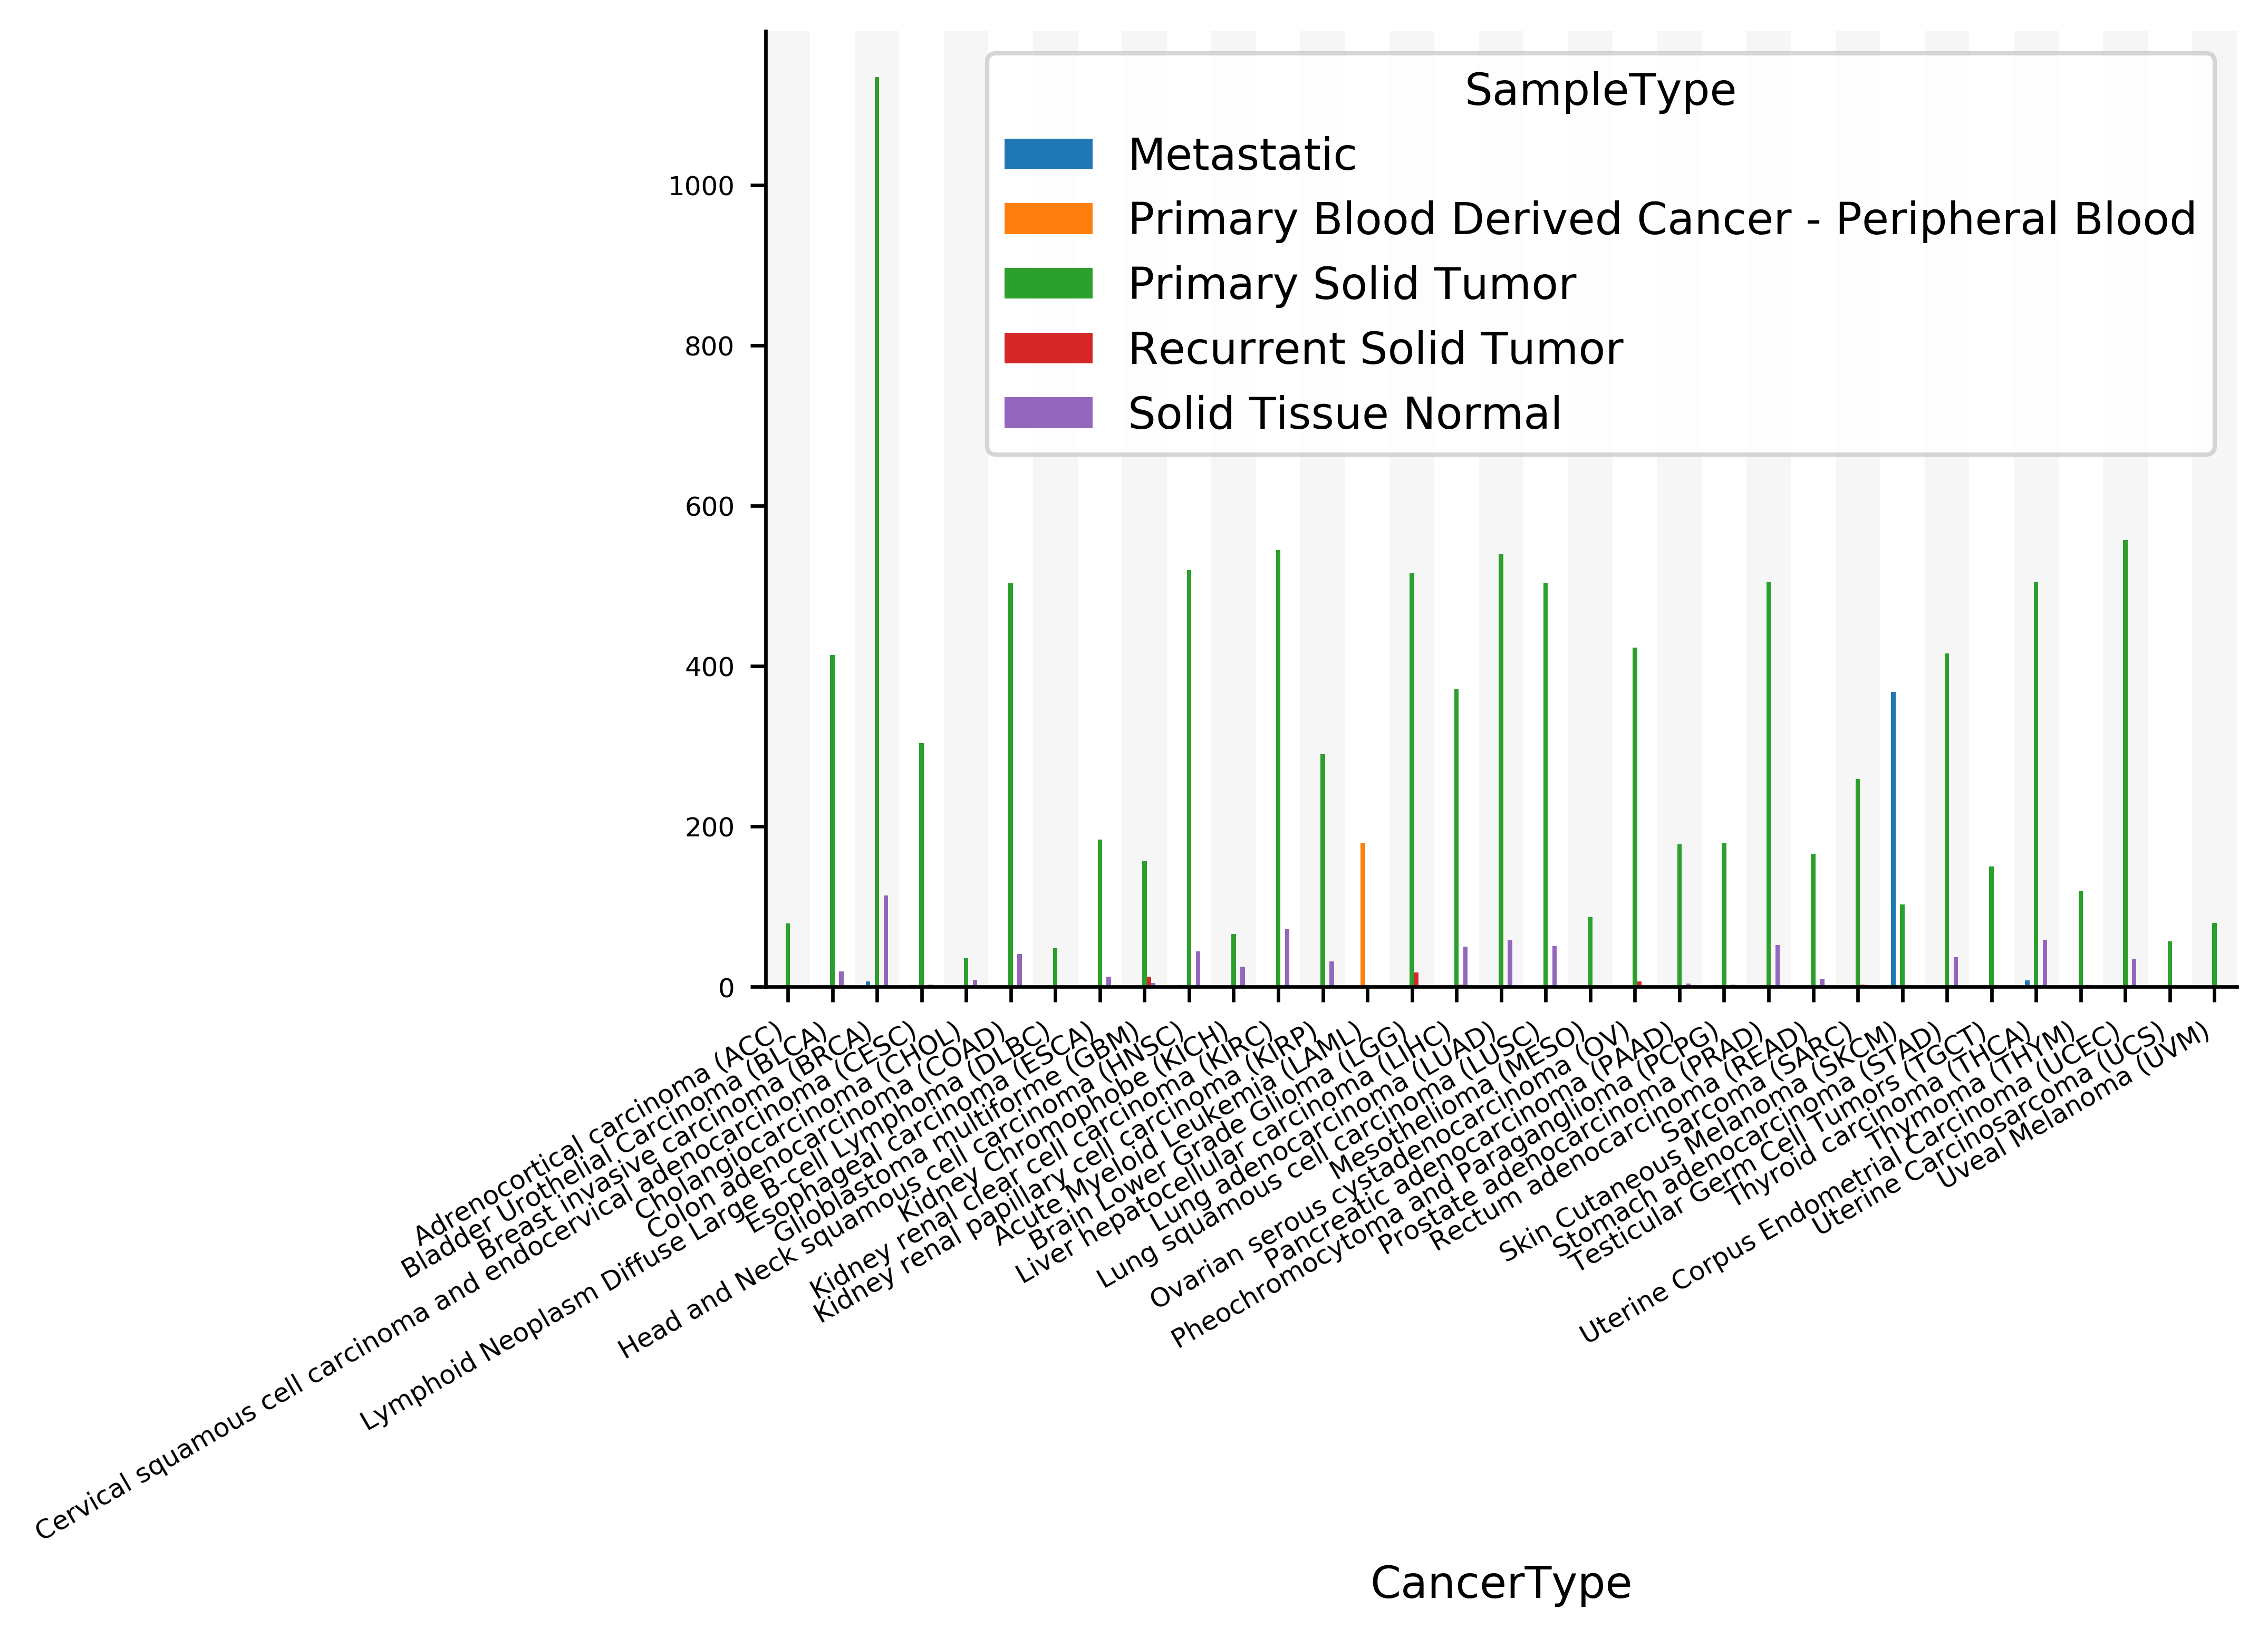

In [12]:
temp = sample_size.copy()
temp.drop('Additional - New Primary', axis = 1, inplace = True)
temp.drop('Additional Metastatic', axis = 1, inplace = True)
temp.index = temp.index.to_series().apply(tcga_study_abbr_dict2.__getitem__)
ax = temp.plot(kind='bar')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.tick_params(axis="y", labelsize=6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=6)

current_ylim = ax.get_ylim()

for i in range(len(sample_size)):
    if i % 2 == 0:
        ax.fill_between([i - 0.5, i + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)
        
ax.set_ylim(current_ylim)

In [13]:
all_data

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,SampleType
0,TCGA-OR-A5JG-01A-11R-A29S-07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.002715,0.026125,0.032788,0.000000,0.010290,0.009607,0.112,0.095797,1.047142,Primary Solid Tumor
1,TCGA-OR-A5LG-01A-11R-A29S-07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.000000,0.007464,0.126237,0.000000,0.000000,0.000000,0.104,0.103345,1.046163,Primary Solid Tumor
2,TCGA-OR-A5JD-01A-11R-A29S-07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.000000,0.009330,0.000000,0.190730,0.000000,0.000000,0.068,0.143259,1.039812,Primary Solid Tumor
3,TCGA-OR-A5LH-01A-11R-A29S-07,ACC,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,...,0.000000,0.000576,0.000000,0.064725,0.000000,0.000000,0.388,0.028763,1.080553,Primary Solid Tumor
4,TCGA-OR-A5KY-01A-11R-A29S-07,ACC,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,...,0.000000,0.042827,0.000000,0.017418,0.014769,0.000000,0.246,0.055621,1.073474,Primary Solid Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,TCGA-V4-A9EQ-01A-11R-A405-07,UVM,0.000000,0.028939,0.008894,0.000000,0.023294,0.015676,0.0,0.002279,...,0.009128,0.000000,0.208036,0.000000,0.000000,0.000000,0.090,0.111538,1.060529,Primary Solid Tumor
11369,TCGA-V4-A9EV-01A-11R-A405-07,UVM,0.000000,0.013299,0.025069,0.315356,0.000000,0.017361,0.0,0.095233,...,0.015558,0.000000,0.061707,0.000000,0.000000,0.000000,0.002,0.347125,0.952021,Primary Solid Tumor
11370,TCGA-V4-A9EY-01A-11R-A405-07,UVM,0.000000,0.032507,0.076160,0.061400,0.034359,0.000000,0.0,0.007778,...,0.004550,0.000000,0.227797,0.000000,0.000000,0.000000,0.086,0.113888,1.041876,Primary Solid Tumor
11371,TCGA-V4-A9EU-01A-11R-A405-07,UVM,0.000000,0.021228,0.010225,0.067985,0.003434,0.006675,0.0,0.004884,...,0.000000,0.000000,0.147489,0.000000,0.000000,0.000000,0.096,0.107852,1.068155,Primary Solid Tumor


In [14]:
cell_types = ['B.cells.naive', 'B.cells.memory', 'Plasma.cells', 'T.cells.CD8',
       'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory..Tregs.', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils']

In [15]:
#all_data['Leukocytes.all'] = all_data[cell_types].sum(1)

all_data['T.cells.all'] = all_data[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

all_data['B.cells.all'] = all_data[['B.cells.naive', 'B.cells.memory']].sum(1)

all_data['Nk.cells.all'] = all_data[['NK.cells.resting', 'NK.cells.activated']].sum(1)

all_data['Macrophages.all'] = all_data[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

all_data['Dendritic.cells.all'] = all_data[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

all_data['Mast.cells.all'] = all_data[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all']

In [16]:
num_data = all_data[augmented_cell_types]
num_data

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,0.000000,0.00000,...,0.032788,0.000000,0.010290,0.009607,0.363818,0.048529,0.072324,0.371050,0.028839,0.032788
1,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,0.000000,0.00000,...,0.126237,0.000000,0.000000,0.000000,0.284199,0.018294,0.039464,0.448243,0.007464,0.126237
2,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,0.000000,0.00000,...,0.000000,0.190730,0.000000,0.000000,0.297711,0.014630,0.070306,0.331188,0.009330,0.190730
3,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,0.000000,0.00000,...,0.000000,0.064725,0.000000,0.000000,0.307141,0.085479,0.101880,0.300020,0.000576,0.064725
4,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,0.000000,0.00000,...,0.000000,0.017418,0.014769,0.000000,0.277398,0.024795,0.032547,0.486499,0.042827,0.017418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,0.000000,0.028939,0.008894,0.000000,0.023294,0.015676,0.0,0.002279,0.026477,0.00000,...,0.208036,0.000000,0.000000,0.000000,0.067725,0.028939,0.051591,0.621272,0.009128,0.208036
11369,0.000000,0.013299,0.025069,0.315356,0.000000,0.017361,0.0,0.095233,0.064945,0.03901,...,0.061707,0.000000,0.000000,0.000000,0.531904,0.013299,0.117556,0.230269,0.015558,0.061707
11370,0.000000,0.032507,0.076160,0.061400,0.034359,0.000000,0.0,0.007778,0.042213,0.00000,...,0.227797,0.000000,0.000000,0.000000,0.145750,0.032507,0.054181,0.443901,0.004550,0.227797
11371,0.000000,0.021228,0.010225,0.067985,0.003434,0.006675,0.0,0.004884,0.023275,0.00000,...,0.147489,0.000000,0.000000,0.000000,0.106254,0.021228,0.032816,0.646112,0.000000,0.147489


In [17]:
skewness = pd.DataFrame(columns = ['CancerType', 'SampleType'] + augmented_cell_types)
kurtosis = pd.DataFrame(columns = ['CancerType', 'SampleType'] + augmented_cell_types)

for cancer_type in sample_size.index:
    for sample_type in sample_size.columns:
        temp = num_data[(all_data.CancerType == cancer_type) & (all_data.SampleType == sample_type)]
        if len(temp) > 100:
            skewness = skewness.append({'CancerType': cancer_type, 'SampleType': sample_type}, ignore_index=True)
            kurtosis = kurtosis.append({'CancerType': cancer_type, 'SampleType': sample_type}, ignore_index=True)
            skewness.iloc[-1, 2:] = temp.skew();
            kurtosis.iloc[-1, 2:] = temp.kurtosis();

In [18]:
skewness

,CancerType,SampleType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
0,BLCA,Primary Solid Tumor,2.6195,2.98644,2.10944,0.855079,2.64735,1.37859,3.10976,1.01205,...,2.14103,2.25974,6.82329,5.3555,0.285444,2.62983,0.780924,0.557402,1.74101,1.57883
1,BRCA,Primary Solid Tumor,1.29924,3.19897,2.27011,0.887054,10.4147,0.574083,5.61973,0.87139,...,1.68471,8.12544,10.4544,4.69624,0.103764,1.83577,1.31117,0.33558,3.24998,1.71785
2,BRCA,Solid Tissue Normal,0.833315,5.48756,1.33937,0.920411,0,1.01858,8.89015,1.6438,...,1.34523,2.69383,4.67156,7.2553,0.239206,0.878892,0.834863,0.430625,1.97535,0.902937
3,CESC,Primary Solid Tumor,2.09966,2.92808,1.93939,0.296236,9.52667,1.21136,2.71832,0.301545,...,1.54,3.29859,10.2748,5.85731,-0.123297,1.70841,2.22409,0.43112,1.42369,2.73511
4,COAD,Primary Solid Tumor,3.47246,2.20726,1.93328,1.38589,6.23422,0.624161,2.35281,0.854649,...,5.58789,1.18011,4.05348,4.04053,0.255024,3.39394,1.03811,0.189989,1.92608,1.33554
5,ESCA,Primary Solid Tumor,1.83556,3.43919,2.68612,1.13276,8.36616,0.268552,2.52356,1.13049,...,2.34311,1.76785,4.12461,3.57097,0.142381,1.79501,1.02039,0.599258,1.34286,1.72599
6,GBM,Primary Solid Tumor,3.12597,2.07887,4.88851,1.39813,8.9393,0.529461,9.30087,2.34333,...,2.07099,2.12941,5.24796,1.04479,0.422901,1.75927,1.41186,0.0355343,2.85258,1.46378
7,HNSC,Primary Solid Tumor,1.96931,3.35802,1.9413,1.09759,5.47037,0.59915,2.70808,0.661008,...,2.85447,2.00503,6.28065,5.37168,0.373264,2.29018,0.922639,0.221442,1.77686,1.94854
8,KIRC,Primary Solid Tumor,4.77872,5.0485,3.32048,0.835299,12.8014,0.247746,6.91561,1.32191,...,2.00727,3.76743,10.5236,14.4665,0.129087,4.56219,1.02671,0.410203,8.25314,1.9122
9,KIRP,Primary Solid Tumor,3.74305,1.73408,3.30186,2.28399,10.7452,0.499949,14.6107,1.85194,...,1.38301,6.65879,8.31589,5.37438,0.927352,2.09167,1.09235,0.0176448,4.33888,1.36471


In [30]:
((skewness.iloc[:, -6:] > -2) & (skewness.iloc[:, -6:] < 2)).sum().sum()  / np.prod(skewness.iloc[:, -6:].shape)

0.7797619047619048

In [31]:
((skewness.iloc[:, -6:] > -3) & (skewness.iloc[:, -6:] < 3)).sum().sum()  / np.prod(skewness.iloc[:, -6:].shape)

0.9047619047619048

In [19]:
((skewness.iloc[:, 2:] > -2) & (skewness.iloc[:, 2:] < 2)).sum().sum()  / np.prod(skewness.iloc[:, 2:].shape)

0.5153061224489796

In [25]:
((skewness.iloc[:, 2:] > -3) & (skewness.iloc[:, 2:] < 3)).sum().sum()  / np.prod(skewness.iloc[:, 2:].shape)

0.6887755102040817

In [20]:
for i in range(-10, 10):
    print(i, i + 1, ((skewness.iloc[:, 2:] >= i) & (skewness.iloc[:, 2:] < i + 1)).sum().sum()  / np.prod(skewness.iloc[:, 2:].shape))

-10 -9 0.0
-9 -8 0.0
-8 -7 0.0
-7 -6 0.0
-6 -5 0.0
-5 -4 0.0
-4 -3 0.0
-3 -2 0.0
-2 -1 0.0012755102040816326
-1 0 0.021683673469387755
0 1 0.20918367346938777
1 2 0.28316326530612246
2 3 0.17346938775510204
3 4 0.09693877551020408
4 5 0.047193877551020405
5 6 0.036989795918367346
6 7 0.04081632653061224
7 8 0.017857142857142856
8 9 0.021683673469387755
9 10 0.008928571428571428


Text(0, 0.5, 'frequency')

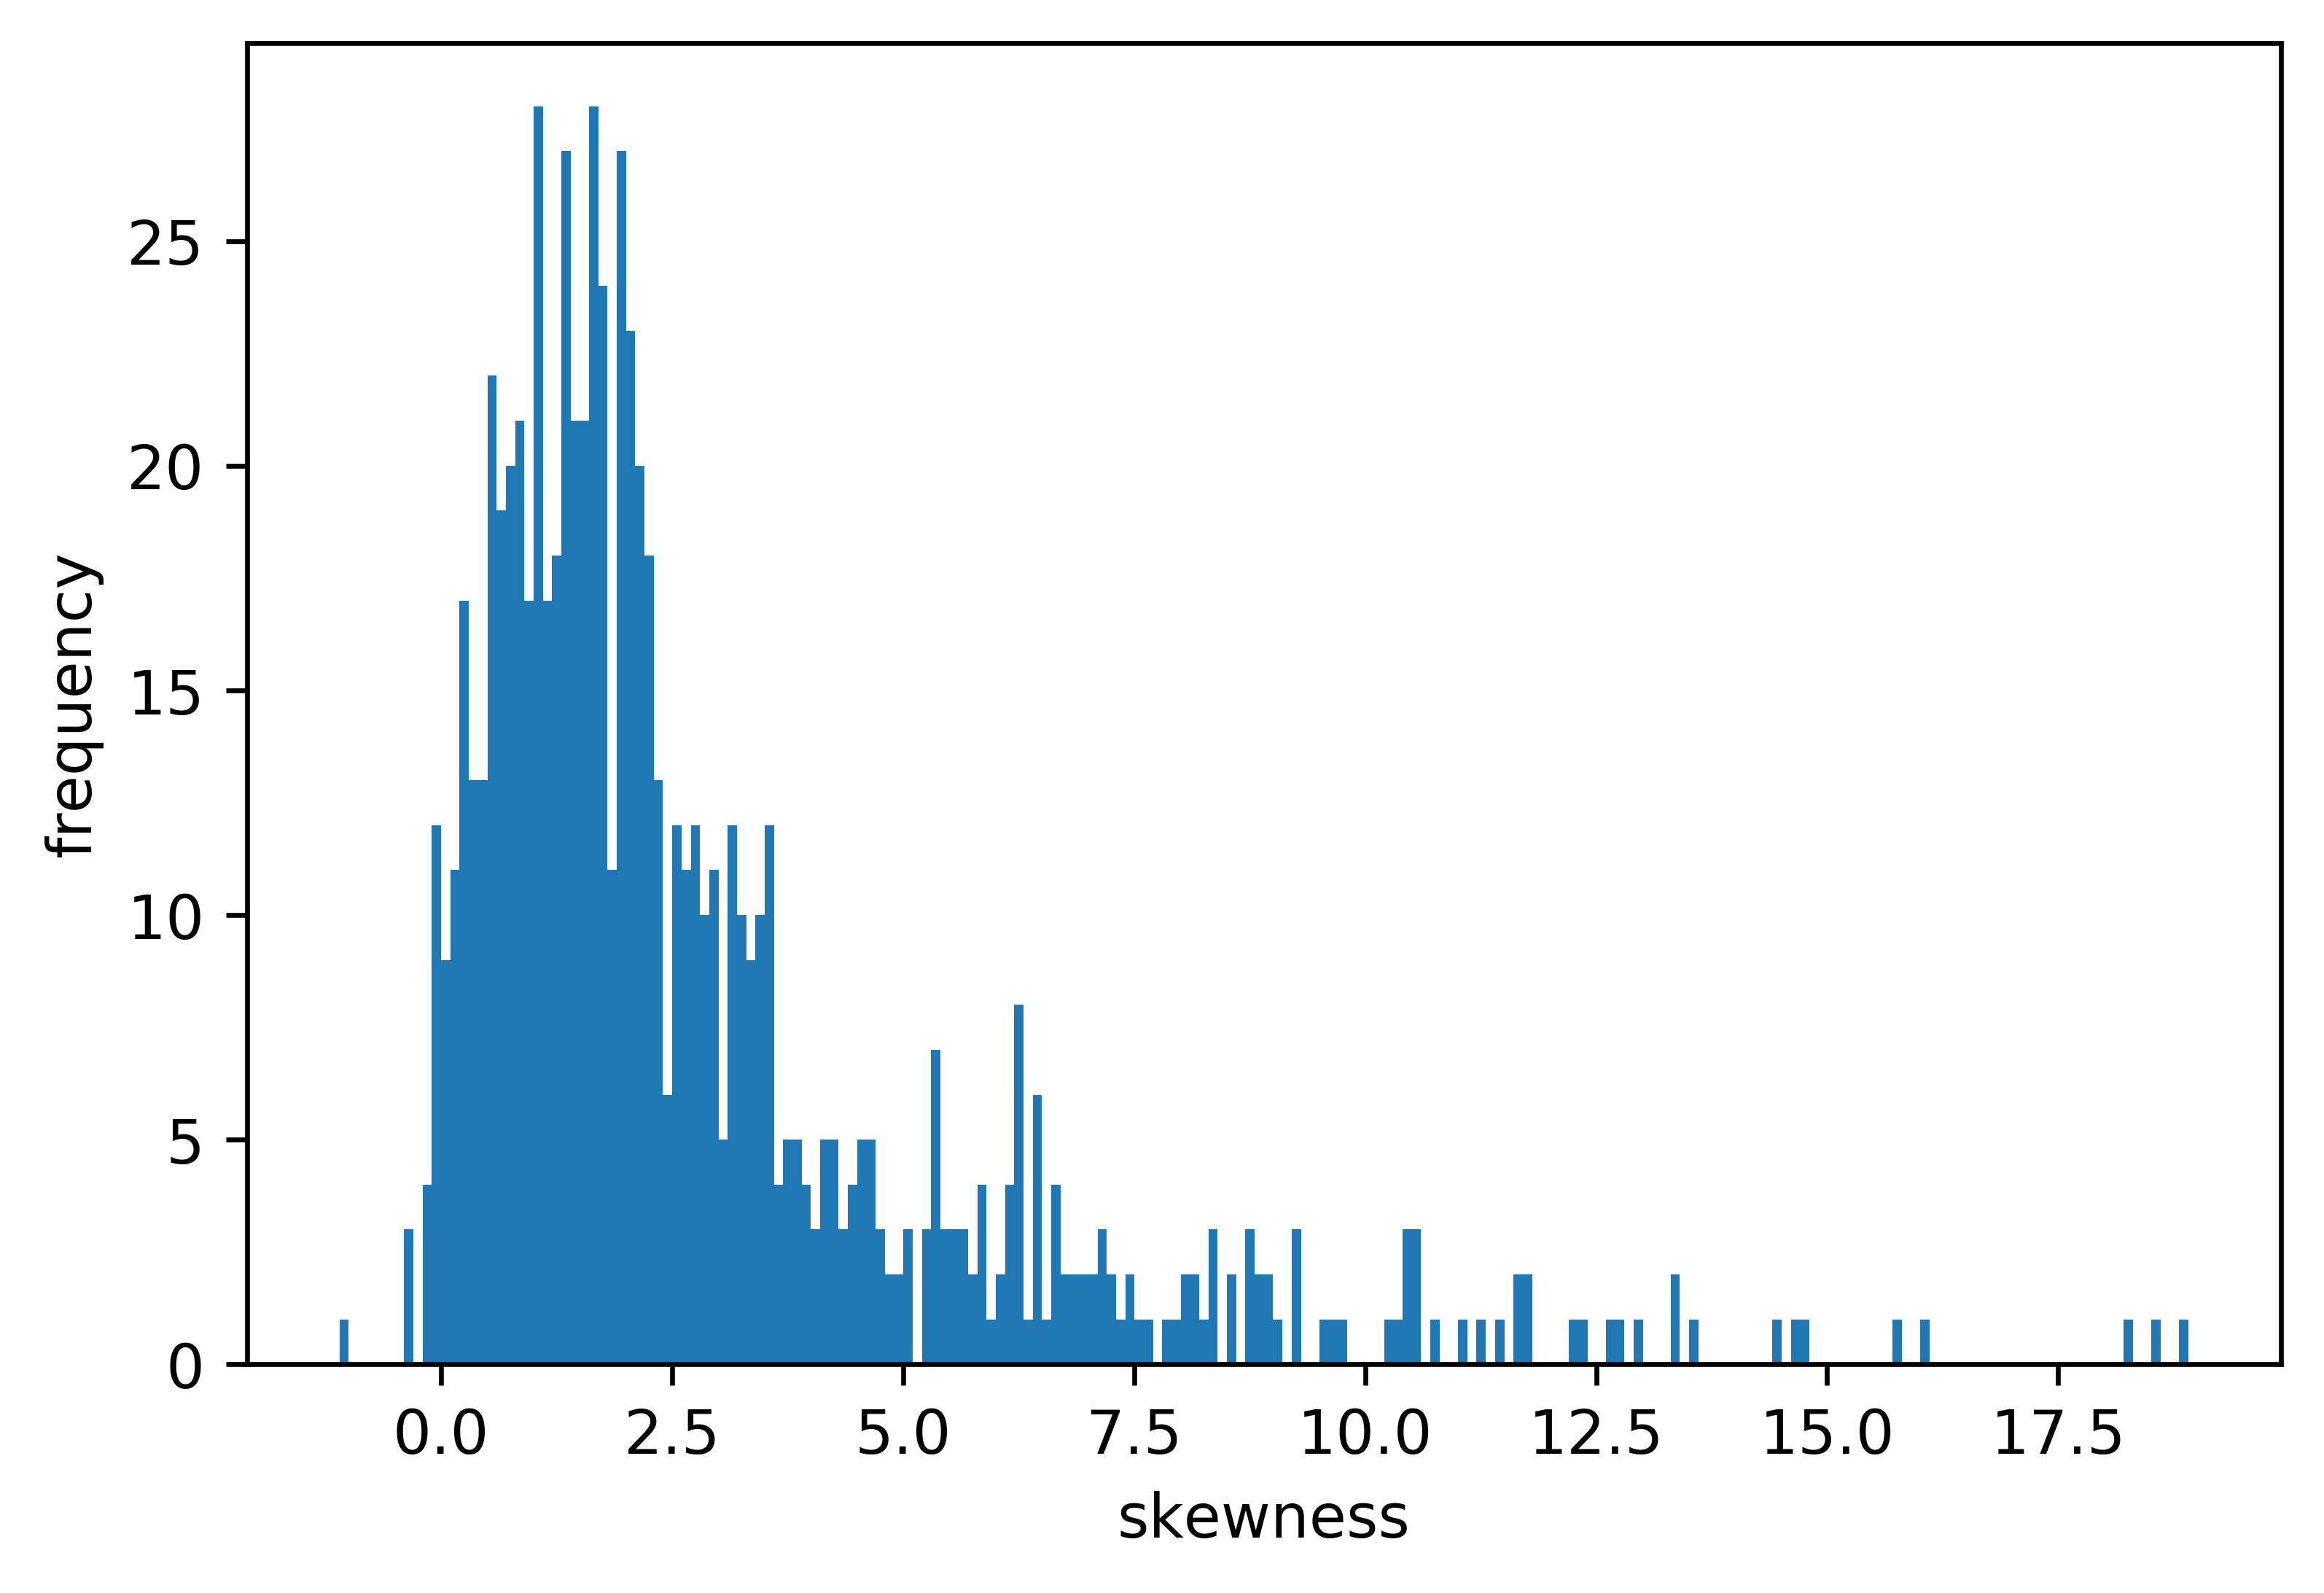

In [21]:
plt.hist(skewness.iloc[:, 2:].values.flatten(), bins=200)
plt.xlabel("skewness")
plt.ylabel("frequency")

In [36]:
((kurtosis.iloc[:, -6:] > -1) & (kurtosis.iloc[:, -6:] < 3)).sum().sum()  / np.prod(kurtosis.iloc[:, -6:].shape)

0.5714285714285714

In [44]:
((kurtosis.iloc[:, -6:] > -1) & (kurtosis.iloc[:, -6:] < 10)).sum().sum()  / np.prod(kurtosis.iloc[:, -6:].shape)

0.875

In [40]:
((kurtosis.iloc[:, 2:] > -1) & (kurtosis.iloc[:, 2:] < 3)).sum().sum()  / np.prod(kurtosis.iloc[:, 2:].shape)

0.39285714285714285

In [45]:
((kurtosis.iloc[:, 2:] > -1) & (kurtosis.iloc[:, 2:] < 10)).sum().sum()  / np.prod(kurtosis.iloc[:, 2:].shape)

0.6632653061224489

In [23]:
for i in range(-3, 10):
    print(i, i + 1, ((kurtosis.iloc[:, 2:] >= i) & (kurtosis.iloc[:, 2:] < i + 1)).sum().sum()  / np.prod(kurtosis.iloc[:, 2:].shape))

-3 -2 0.0
-2 -1 0.0012755102040816326
-1 0 0.10204081632653061
0 1 0.1326530612244898
1 2 0.08673469387755102
2 3 0.07142857142857142
3 4 0.061224489795918366
4 5 0.06887755102040816
5 6 0.04081632653061224
6 7 0.030612244897959183
7 8 0.021683673469387755
8 9 0.026785714285714284
9 10 0.02040816326530612


Text(0, 0.5, 'frequency')

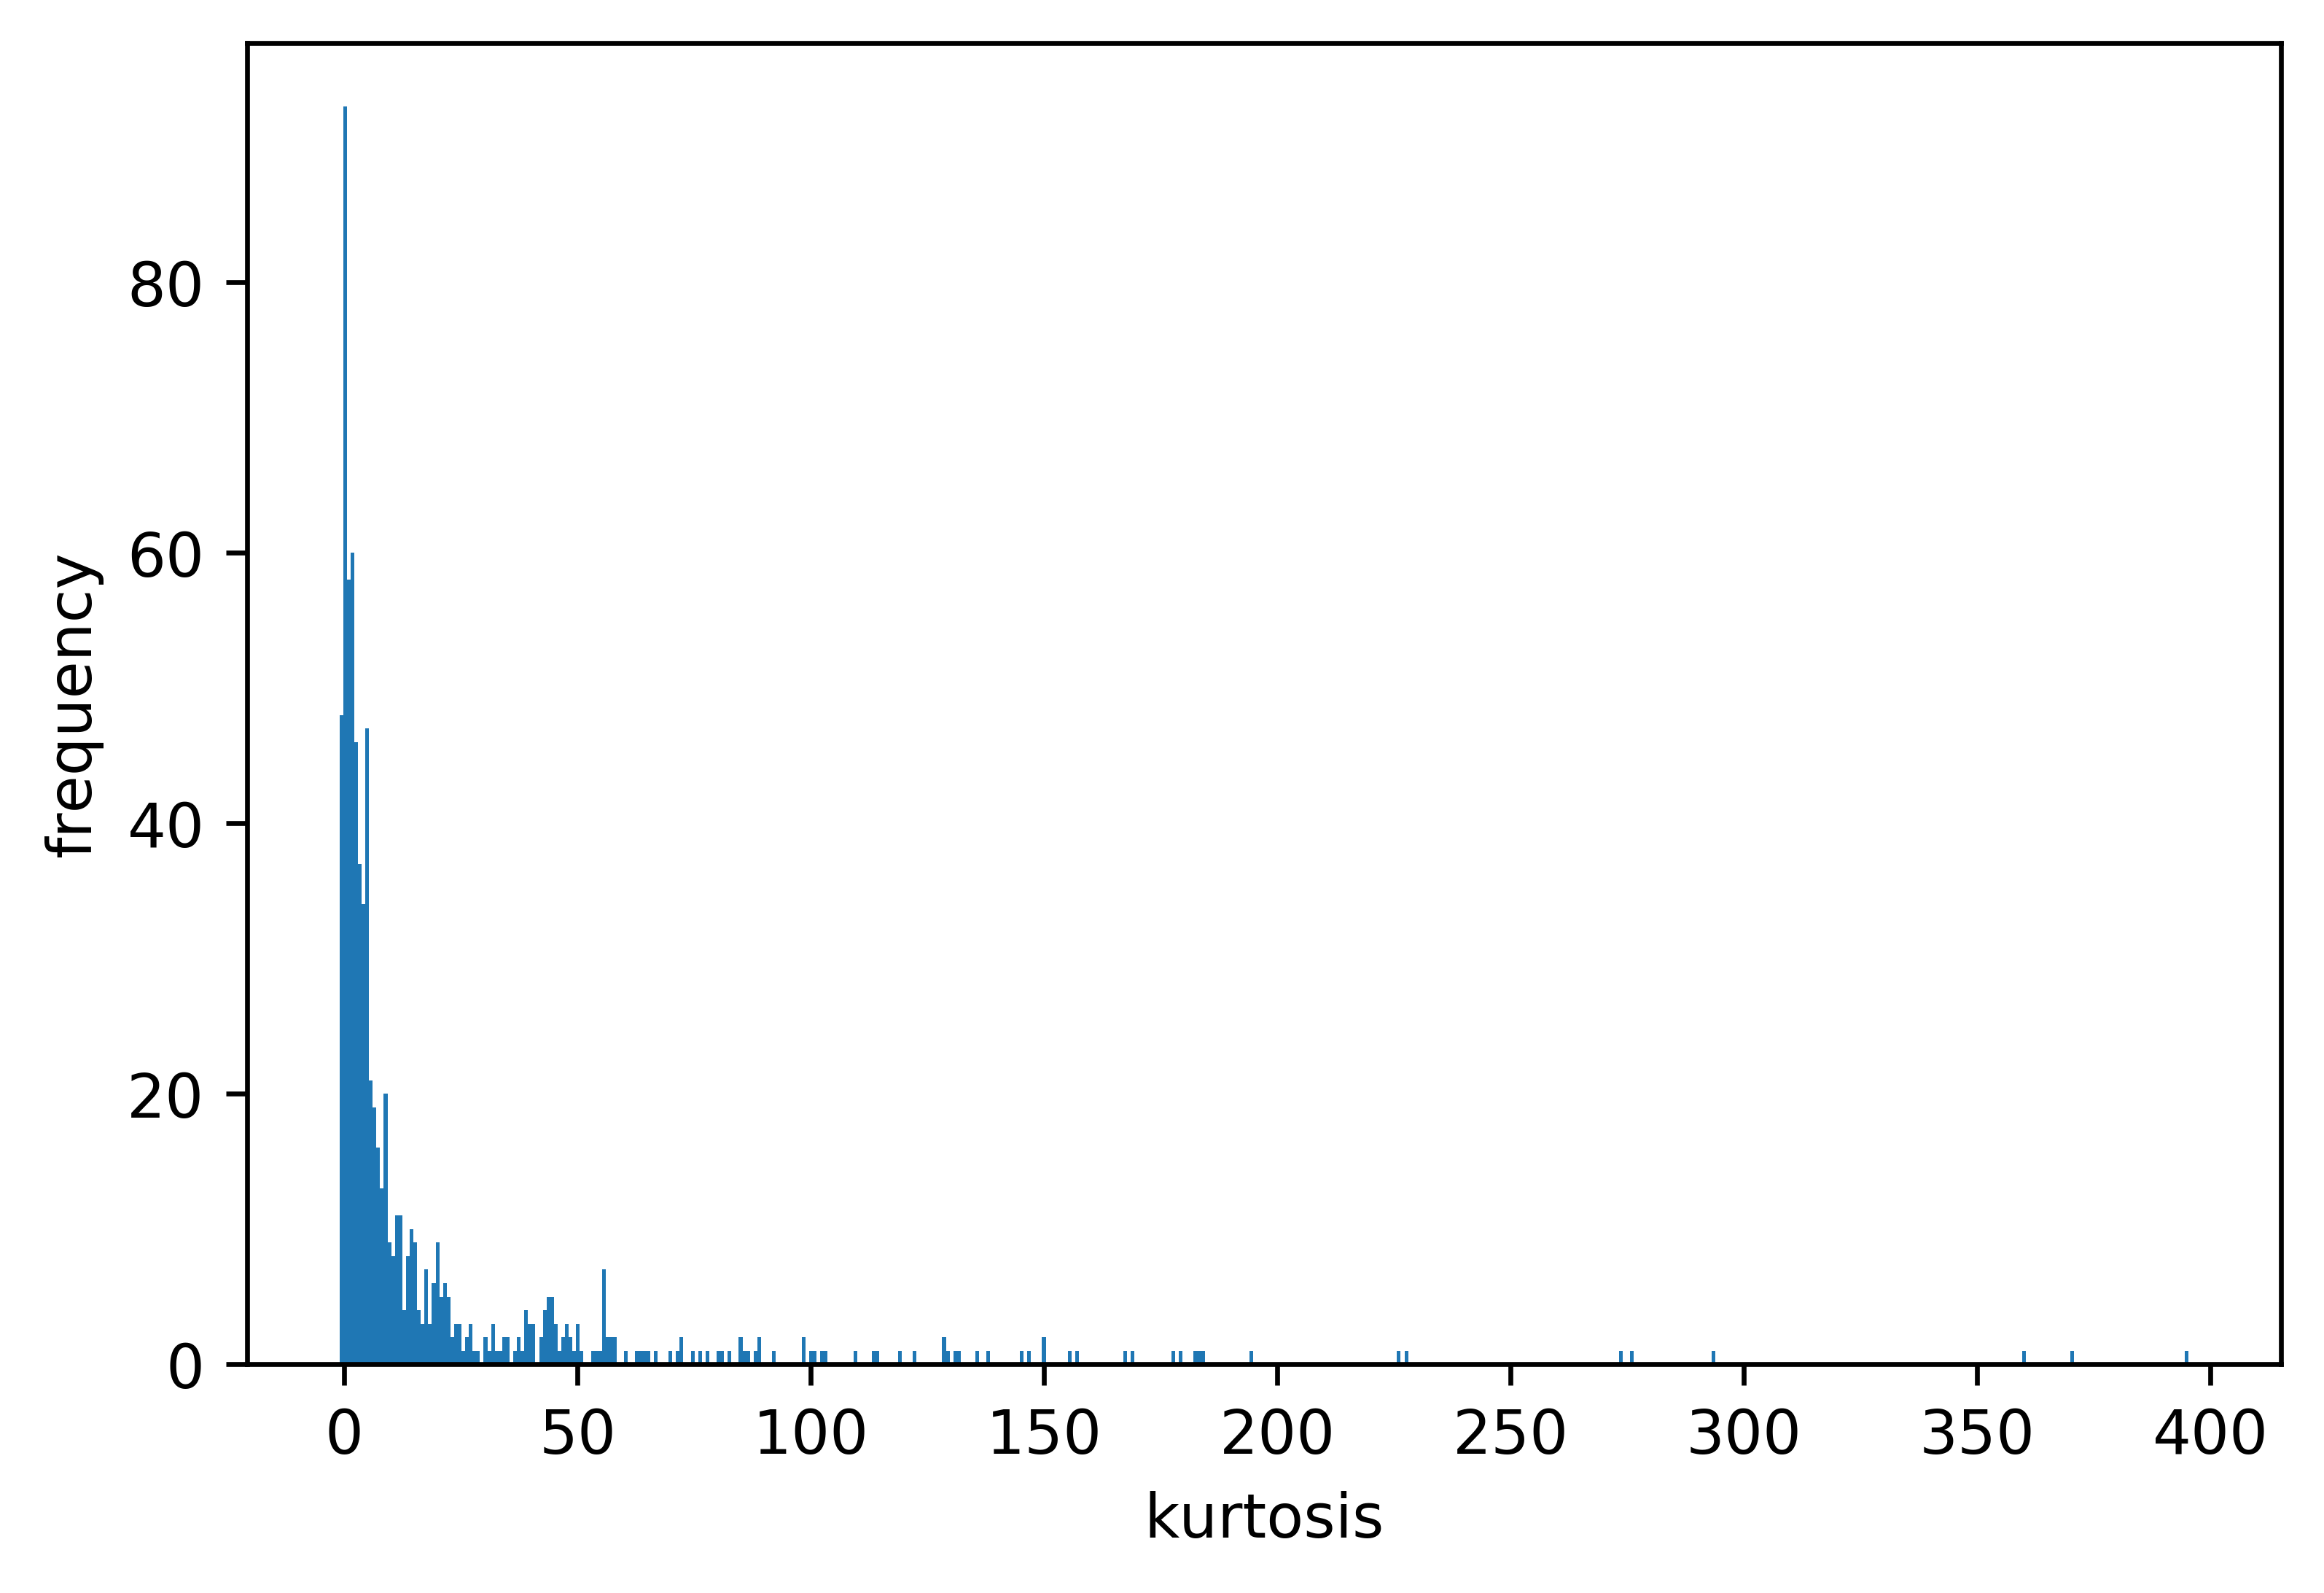

In [24]:
plt.hist(kurtosis.iloc[:, 2:].values.flatten(), bins=500)
plt.xlabel("kurtosis")
plt.ylabel("frequency")